# Feature Engineering for Standup Scripts
## Goal: Generate useful features related to standup comedy style.

## Table of Contents

   - [x] [imports](#imports)
   - [x] [prepare the data](#prepare-the-data)
   - [x] [word lengths](#word-lengths)
   - [x] [distinct words](#distinct-words)
   - [x] [words per minute and sentences per minute](#words-per-minute-and-sentences-per-minute)
   - [ ] [repetition and phrases](#repetition-and-phrases)
       - [with gensim](#with-gensim)
       - [with sklearn](#with-sklearn)
   - [x] [profanity](#profanity)
   - [ ] [part-of-speech frequencies](#part-of-speech-frequencies)
   - [ ] [sentence structure](#sentence-structure)
   - [ ] [point of view](#point-of-view)
   - [ ] [cosine similarities](#cosine-similarities)
   - [playground](#playground)

## imports 


In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import date
import json
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import re
from collections import Counter, defaultdict
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
import gensim
from gensim.corpora.dictionary import Dictionary
import spacy

import warnings
warnings.filterwarnings('ignore')

In [2]:
sw = stopwords.words("english")

In [3]:
transcripts_df = pd.read_pickle('../data/transcripts_raw_df.pickle')

In [4]:
with open(f'../data/imdb_title_results_2022-05-23.pickle', 'rb') as file:
    show_meta = pickle.load(file)

In [5]:
with open(f'../data/metascripts_df_2022-05-28.pickle', 'rb') as file:
    metascripts = pickle.load(file)

In [6]:
with open("../data/profane_to_replace.pickle", 'rb') as file:
    to_replace = pickle.load(file)
    
with open("../data/profane_replace_with.pickle", 'rb') as file:
    replace_with = pickle.load(file)

In [7]:
nonenglish_shows = ['BILL BURR: WHY DO I DO THIS (2008) – Testo italiano completo',
                   'DOUG STANHOPE: NO REFUNDS (2007) – Trascrizione italiana',
                   'GEORGE CARLIN: JAMMING IN NEW YORK (1992) – Testo italiano completo',
                   'GEORGE CARLIN: YOU ARE ALL DISEASED (1999) – Testo italiano completo',
                   'GEORGE CARLIN: IT’S BAD FOR YA! (2008) – Testo italiano completo',
                   'DAVE CHAPPELLE: THE BIRD REVELATION (2017) – Transcripción completa']

In [8]:
metascripts = metascripts[~metascripts['description'].isin(nonenglish_shows)]

In [9]:
metascripts.shape

(310, 24)

## prepare the data


In [10]:
# Replace bracket and parenthetical content from scripts
metascripts['transcript'] = (metascripts['transcript']
                                 .replace("\[.+?\]|\(.+?\)","", regex = True)
                                 .replace("\’|\‘", "'", regex = True)
                                 .replace("\“|\”", '"', regex = True)
                                 .replace(to_replace[0], replace_with[0], regex = True)
                                 .replace(to_replace[1], replace_with[1], regex = True)
                            )

In [11]:
# Fill censored words to clean up our profanity detection
profanity_fill = json.load(open('../data/profanity_fill.json'))

for key, value in profanity_fill.items(): 
    metascripts['transcript'] = metascripts['transcript'].str.replace(key, value, regex = False)

In [12]:
transcripts_dict = dict(zip(metascripts['description'].values, metascripts['transcript'].values))

In [13]:
descriptions = list(transcripts_dict.keys())
scripts = list(transcripts_dict.values())

In [14]:
parens = (re.findall(r"\(.+?\)", script) for script in scripts)
[(ind, len(matches)) for ind, matches in enumerate(parens) if len(matches) > 0]
parenscripts = (scripts[ind] for ind, matches in enumerate(parens) if len(matches) > 0)

## word lengths
word lengths are calculated as letters per word

   * tokenize words (allow apostrophes and dashes but not numbers)
   * do not lemmatize
   * do not remove stopwords
   
[to the top](#Feature-Engineering-for-Standup-Scripts)

In [15]:
bow_cased = [regexp_tokenize(transcript, r"[a-zA-Z]+") for description, transcript in transcripts_dict.items()]
bow_counter = [Counter(word.lower() for word in script_words) for script_words in bow_cased]

tokenized_list = [[word.lower() for word in script_words] for script_words in bow_cased]
dictionary = Dictionary(tokenized_list)
corpus = [dictionary.doc2bow(script) for script in tokenized_list]

In [16]:
word_lengths = [[len(word) for word in script_words] for script_words in tokenized_list]

In [17]:
metascripts['mean word length'] = [np.mean(script_word_lengths) for script_word_lengths in word_lengths]
metascripts['std word length'] = [np.std(script_word_lengths) for script_word_lengths in word_lengths]

for quantile in (0.25, 0.50, 0.75):
    metascripts[f'Q{quantile/0.25} word length'] = [np.quantile(script_word_lengths, quantile) for script_word_lengths in word_lengths]

metascripts['max word length'] = [np.max(script_word_lengths) for script_word_lengths in word_lengths]

## sentence lengths
sentence lengths are calculated as words per sentence

   * tokenize sentences and then count whitespaces
   * do not remove stopwords
   * get arrays so we can do mean, median, boxplot values, standard deviation
   
[to the top](#Feature-Engineering-for-Standup-Scripts)

In [18]:
sent_tokenized_list = [sent_tokenize(transcript) for description, transcript in transcripts_dict.items()]
sent_words_tokenized_list = [[regexp_tokenize(sent, r"['\-\w]+") for sent in sent_script] for sent_script in sent_tokenized_list]
sent_lengths = [[len(sent) for sent in script] for script in sent_words_tokenized_list]
sent_counts = [len(script) for script in sent_tokenized_list]

In [19]:
metascripts['mean sentence length'] = [np.mean(script_sent_lengths) for script_sent_lengths in sent_lengths]
metascripts['std sentence length'] = [np.std(script_sent_lengths) for script_sent_lengths in sent_lengths]

for quantile in (0.25, 0.50, 0.75):
    metascripts[f'Q{quantile/0.25} sentence length'] = [np.quantile(script_sent_lengths, quantile) for script_sent_lengths in sent_lengths]

metascripts['max sentence length'] = [np.max(script_sent_lengths) for script_sent_lengths in sent_lengths]

## distinct words
count distinct words in each show and normalize by determining the proportion of distinct words and distinct words per sentence

   * tokenize: allow apostrophes and dashes but not numbers 
   * lemmatize
   
[to the top](#Feature-Engineering-for-Standup-Scripts)

In [20]:
from nltk.stem.wordnet import WordNetLemmatizer

In [21]:
lemmatizer = WordNetLemmatizer()
lem_counter = [Counter(lemmatizer.lemmatize(word.lower()) for word in script_words) for script_words in bow_cased]

In [22]:
unique_word_counts = [len(script_lem_counts) for script_lem_counts in lem_counter]
total_word_counts = [np.sum([count for lem, count in script_lem_counts.items()]) for script_lem_counts in lem_counter]
unique_total_ratio = [unique/total for unique, total in zip(unique_word_counts, total_word_counts)]
unique_per_sent = [unique/sent_count for unique, sent_count in zip(unique_word_counts, sent_counts)]

In [23]:
metascripts['unique words'] = unique_word_counts
metascripts['total words'] = total_word_counts
metascripts['proportion unique words'] = unique_total_ratio
metascripts['unique words per sentence'] = unique_per_sent

## words per minute and sentences per minute

In [24]:
word_tok_scripts = [regexp_tokenize(script, r"[\w'-]+") for script in scripts]
words_per_minute = [len(script_words)/minutes for script_words, minutes in zip(word_tok_scripts, metascripts['runtimeMins'].values)]

sent_tok_scripts = [sent_tokenize(script) for script in scripts]
sent_per_minute = [len(script_sentences)/minutes for script_sentences, minutes in zip(sent_tok_scripts, metascripts['runtimeMins'].values)]

In [25]:
metascripts['words per minute'] = words_per_minute
metascripts['sentences per minute'] = sent_per_minute

## repetition and phrases
I've found three ways to get ngrams:

   1. Using Gensim's [Phrases model](https://radimrehurek.com/gensim_3.8.3/models/phrases.html) iteratively across the corpus, where the kth iteration creates a kgram
   2. Using one of SKLearn's text feature extraction modules [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) or [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer), which is equivalent to the CountVectorizer followed by the [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer)
   
[to the top](#Feature-Engineering-for-Standup-Scripts)

### with gensim

In [26]:
from gensim.models import Phrases

In [27]:
tok_scripts = [regexp_tokenize(transcript, r"['\-\w]+") for description, transcript in transcripts_dict.items()]
docs_lem = [[lemmatizer.lemmatize(tok.lower()) for tok in transcript] for transcript in tok_scripts]
docs_no_lem = [[tok.lower() for tok in transcript] for transcript in tok_scripts]

In [28]:
# still not picking up anything greater than a bigram. May need to reduce the Phrases threshold.

def append_ngrams(docs, ngram):
    for idx in range(len(docs)):
        for token in ngram[docs[idx]]:
            if '_' in token:
                # if token is an ngram, add to document.
                docs[idx].append(token)
    return docs

def make_ngrams(tok_corpus, with_dict = False, lemmatize = True, max_n = 2, min_count = 5, **kwargs):
    ngram_dict = {}
    if lemmatize:
        docs = [[lemmatizer.lemmatize(tok.lower()) for tok in transcript] for transcript in tok_corpus]
    else:
        docs = [[tok.lower() for tok in transcript] for transcript in tok_corpus]
    for n in range(2, max_n+1):
        if n == 2:
            ngram_dict[f'{str(n)}grams'] = Phrases(docs, min_count = min_count, **kwargs)
        else:
            ngram_dict[f'{str(n)}grams'] = Phrases(ngram_dict[f'{str(n-1)}grams'][docs], min_count = min_count, **kwargs)
    docs = append_ngrams(docs, ngram_dict[f'{str(max_n)}grams'])
    if with_dict:
        return docs, ngram_dict
    else:
        return docs

In [29]:
docs, ngram_dict = make_ngrams(tok_scripts, with_dict = True, lemmatize = True, max_n = 4, min_count = 1, threshold = 1)

In [30]:
ngram_dict

{'2grams': <gensim.models.phrases.Phrases at 0x26f72c47a60>,
 '3grams': <gensim.models.phrases.Phrases at 0x26f72c47af0>,
 '4grams': <gensim.models.phrases.Phrases at 0x26f72c47040>}

In [31]:
for ind in range(len(docs)):
    c = Counter(tok for tok in docs[ind] if re.search("(.+_){2}", tok))
    if len(c) > 0:
        print(c)

Counter({'__quarteroid__': 2})
Counter({'lick_my_ass': 2})


In [32]:
[(descriptions[ind], len(re.findall("what is that", script.lower()))) for ind, script in enumerate(scripts) if len(re.findall("what is that", script.lower())) > 0 ][15:19]

[('JIM NORTON: AMERICAN DEGENERATE (2013) – FULL TRANSCRIPT', 1),
 ('CHRIS D’ELIA: WHITE MALE. BLACK COMIC. (2013) – FULL TRANSCRIPT', 1),
 ('Bert Kreischer: Hey Big Boy (2020) – Transcript', 1),
 ('Marc Maron: End Times Fun (2020) – Full Transcript', 4)]

### with sklearn

In [33]:
# import pyLDAvis
# import pyLDAvis.sklearn
# pyLDAvis.enable_notebook()

# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.decomposition import LatentDirichletAllocation

In [34]:
# %%timeit
# ct_vectorizer = CountVectorizer(lowercase = True, 
#                              token_pattern = r"\b[a-zA-z][a-zA-Z\-']*\b", 
#                              ngram_range = (1, 4),
#                              stop_words = "english",
                             
#                             )
# scripts_tf = ct_vectorizer.fit_transform(scripts)

# tfidf_vectorizer = TfidfVectorizer(**ct_vectorizer.get_params())
# scripts_tfidf = tfidf_vectorizer.fit_transform(scripts)

In [35]:
# tfidf_vectorizer.get_feature_names_out()[8000:8015]

In [36]:
# scripts_tf

## profanity
There are several options for detecting profanity. Three prominent ones are

   - [x] [profanity-filter](#https://pypi.org/project/profanity-filter/): a sophisticated, word-list-based package with boolean methods like is_profane
   - [ ] [profanity-check](#https://pypi.org/project/alt-profanity-check/): a model-based approach to profanity detection compatible with spaCy
   - [ ] [better-profanity](#https://pypi.org/project/better-profanity/): another list-based approach, though less accurate than profanity-filter
   
profanity-filter is the most appropriate for this project. While a model-based approach is appealing, it's more likely to identify words or sentences as profane because the sentence has the structure of an insult. For instance, if a comedian says, "That guy is a dingleberry," profanity-check would flag it as profane, while profanity-filter would not.
   
[to the top](#Feature-Engineering-for-Standup-Scripts)

In [37]:
from profanityfilter import ProfanityFilter

In [38]:
pf = ProfanityFilter()
tok_scripts = [regexp_tokenize(transcript, r"\b[a-zA-Z'\w\-\*]+\b") for transcript in scripts]
tok_scripts_lc = [[token.lower() for token in script] for script in tok_scripts]
word_counts = [Counter(token for token in script) for script in tok_scripts_lc]

In [39]:
dictionary = Dictionary(tok_scripts_lc)
corpus = [dictionary.doc2bow(script) for script in tok_scripts_lc]

In [40]:
#[dictionary.id2token(token) for token in dictionary.iterkeys()]
corpus_overall_counts = {}
for bow in tqdm(corpus):
    for id, count in bow:
        if dictionary[id] in corpus_overall_counts.keys():
            corpus_overall_counts[dictionary[id]] += count
        else:
            corpus_overall_counts[dictionary[id]] = count

  0%|          | 0/310 [00:00<?, ?it/s]

In [41]:
# profane_dict = {word: pf.is_profane(word) for word in tqdm(corpus_overall_counts)}

In [42]:
# with open('../data/profanity_booleans_no_lemma.pickle', 'wb') as file:
#     pickle.dump(profane_dict, file)

In [43]:
with open('../data/profanity_booleans_no_lemma.pickle', 'rb') as file:
    profane_dict = pickle.load(file)

In [44]:
profanity_counts = {description: {word:count for word, count in script_counts.items() if profane_dict[word]} for script_counts, description in zip(word_counts,descriptions)}

KeyError: 'nigga-ttendant'

In [ ]:
profane_words = [sum(words.values()) for description, words in profanity_counts.items()]
total_words = [sum(script_word_counts.values()) for script_word_counts in word_counts]
profane_proportion = [profane/total for profane, total in zip(profane_words, total_words)]
profane_per_sent = [profane/sent_count for profane, sent_count in zip(profane_words, sent_counts)]
profane_per_min = [profane/minutes for profane, minutes in zip(profane_words, metascripts['runtimeMins'].values)]

In [ ]:
metascripts['profane count'] = profane_words
metascripts['profane proportion'] = profane_proportion
metascripts['profanity per sentence'] = profane_per_sent
metascripts['profanity per minute'] = profane_per_min

In [ ]:
px.box(metascripts, x = 'profanity per minute', hover_data = ['description', 'profane count'], points = 'all')

## part-of-speech frequencies

In [121]:
# instantiate the English model: nlp
nlp = spacy.load('en_core_web_md')

# create chunker to manage memory usage
def chunker(iterable, chunksize):
    for i in range(0, len(list(iterable)), chunksize):
        yield iterable[i:i+chunksize]

# create function that builds a dictionary from pos counts
def get_doc_pos_count(doc):
    pos_dict = {}
    for token in doc:
        if token.pos_ in pos_dict.keys():
            pos_dict[token.pos_] += 1
        else:
            pos_dict[token.pos_] = 1
    return pos_dict

# stream scripts in chunks through the nlp pipe, make pos counts dictionaries, and append to complete list
docs_pos_counts = []
for scripts_subset in tqdm(chunker(scripts, 10), total = np.ceil(len(scripts)/10)):
    subset_list = [get_doc_pos_count(doc) for doc in nlp.pipe(scripts_subset)]
    docs_pos_counts.extend(subset_list)

  0%|          | 0/31.0 [00:00<?, ?it/s]

In [126]:
# turn list of dictionary counts to dictionary of dictionary counts of only actual words
docs_pos_counts_words = [{pos: count for pos, count in count_dict.items() if pos not in ['PUNCT', 'SPACE', 'X']} for count_dict in docs_pos_counts]
show_pos_counts = dict(zip(descriptions, docs_pos_counts_words))

# create dictionary of dictionaries of pos proportions by show
show_pos_props = {description: {pos: count/sum(counts_dict.values()) for pos, count in counts_dict.items()} for description, counts_dict in show_pos_counts.items()}

In [133]:
# create pos proportion dataframe, pos_df
pos_df = (pd.DataFrame.from_dict(show_pos_props, orient = 'index')
                      .fillna(0)
                      .reset_index()
                      .rename(columns = {'index':'description'})
        )
pos_df

,description,VERB,PRON,INTJ,NOUN,ADV,AUX,ADJ,PART,ADP,DET,SCONJ,CCONJ,PROPN,NUM,SYM
0,Jim Gaffigan: Comedy Monster (2021) | Transcript,0.146510,0.184963,0.017147,0.145698,0.062906,0.106230,0.053673,0.037845,0.081981,0.077922,0.024046,0.027902,0.025974,0.007204,0.000000
1,Louis C. K.: Sorry (2021) | Transcript,0.140020,0.206552,0.016381,0.133737,0.057669,0.106361,0.057556,0.039942,0.076517,0.074274,0.030405,0.029507,0.021317,0.008639,0.001122
2,Drew Michael: Drew Michael (2018) | Transcript,0.136785,0.216978,0.043468,0.119326,0.058519,0.116918,0.053341,0.040698,0.083925,0.060566,0.027694,0.026851,0.007586,0.007345,0.000000
3,Drew Michael: Red Blue Green (2021) | Transcript,0.140336,0.199783,0.022306,0.133947,0.055658,0.107959,0.052518,0.045479,0.087168,0.069193,0.026096,0.029020,0.021332,0.009204,0.000000
4,Mo Amer: Mohammed in Texas (2021) | Transcript,0.134704,0.207911,0.027945,0.133917,0.061694,0.104300,0.051855,0.031388,0.085309,0.065729,0.017810,0.026567,0.041622,0.009151,0.000098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,GEORGE CARLIN: COMPLAINTS AND GRIEVANCES (2001...,0.139356,0.163515,0.011204,0.166433,0.056723,0.079132,0.063025,0.038982,0.092787,0.083217,0.018441,0.032096,0.044118,0.010854,0.000117
306,GEORGE CARLIN: LIFE IS WORTH LOSING (2006) – T...,0.143898,0.150713,0.008538,0.181654,0.055616,0.074886,0.075748,0.035172,0.089456,0.092355,0.017233,0.037130,0.026007,0.011593,0.000000
307,George Carlin: It’s Bad For Ya (2008) Full tra...,0.147432,0.165814,0.012886,0.154539,0.057703,0.090203,0.063578,0.039227,0.084707,0.083002,0.021508,0.032405,0.034395,0.012507,0.000095
308,Dave Chappelle: 8:46 – Transcript,0.140195,0.181085,0.008345,0.139638,0.040890,0.091516,0.053686,0.035883,0.079555,0.088178,0.025591,0.037274,0.063421,0.014465,0.000278


In [173]:
# pickle pos_df for future use
with open('../data/pos_props_df.pickle', 'wb') as file:
    pickle.dump(pos_df, file)

# read in pos_df
with open('../data/pos_props_df.pickle', 'rb') as file:
    pos_df = pickle.load(file)

In [176]:
pos_col = 'VERB'
px.box(pos_df, x = pos_col, hover_data = ['description'], points = 'all')

## sentence structure

## point-of-view

In [186]:
word_counts_dicts = [{dictionary[entry[0]]: entry[1] for entry in index_counts} for index_counts in corpus]

In [191]:
first_pron = ["i",
            "me",
            "my",
            "mine",
            "myself",
            "we",
            "us",
            "our",
            "ours,"
            "ourselves"]

second_pron = ["you",
               "your",
               "yours"]

third_pron = ["he",
            "she",
            "it",
            "him",
            "her",
            "it",
            "his",
            "her",
            "its",
            "his",
            "hers",
            "its",
            "they",
            "them",
            "their",
            "theirs"]

In [193]:
from collections import defaultdict

def count_pov(word_dict, pos_dict):
    pov_dict = defaultdict(int)
    for word, count in word_dict.items():
        if word in first_pron:
            pov_dict['first_person'] += count
        elif word in second_pron:
            pov_dict['second_person'] += count
        elif word in third_pron:
            pov_dict['third_person'] += count
    pov_dict['third_person'] += pos_dict['NOUN'] + pos_dict['PROPN']
    return dict(pov_dict)

In [201]:
pov_counts = [count_pov(word_count_dict, pos_count_dict) for word_count_dict, pos_count_dict in zip(word_counts_dicts, docs_pos_counts_words)]
pov_props_overall = [{pov: count/sum(word_count_dict.values()) for pov, count in pov_count_dict.items()} for pov_count_dict, word_count_dict in zip(pov_counts, word_counts_dicts)]
pov_props_relative = [{pov: count/sum(pov_count_dict.values()) for pov, count in pov_count_dict.items()} for pov_count_dict in pov_counts]

In [202]:
pov_props_relative

[{'third_person': 0.6950404502286317,
  'first_person': 0.20295462539570877,
  'second_person': 0.10200492437565951},
 {'third_person': 0.7183505154639175,
  'first_person': 0.1797938144329897,
  'second_person': 0.10185567010309278},
 {'third_person': 0.614691943127962,
  'first_person': 0.23554502369668245,
  'second_person': 0.14976303317535544},
 {'third_person': 0.7038950715421304,
  'first_person': 0.18640699523052465,
  'second_person': 0.10969793322734499},
 {'third_person': 0.6971993410214168,
  'first_person': 0.1799011532125206,
  'second_person': 0.12289950576606261},
 {'third_person': 0.7053401144310235,
  'first_person': 0.22441195168467895,
  'second_person': 0.07024793388429752},
 {'third_person': 0.6999419616947186,
  'first_person': 0.20835751596053395,
  'second_person': 0.09170052234474753},
 {'third_person': 0.6794871794871795,
  'first_person': 0.21153846153846154,
  'second_person': 0.10897435897435898},
 {'third_person': 0.7530811729706758,
  'first_person': 0.1

## cosine similarity

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

In [153]:
def token_filter(token):
    return not (token.is_punct | token.is_space | token.is_stop)

filtered_tokens = []
for scripts_subset in tqdm(chunker(scripts, 2), total = np.ceil(len(scripts)/2)):
    for doc in nlp.pipe(scripts_subset):
        tokens = [token.lemma_.lower() for token in doc if token_filter(token)]
        filtered_tokens.append(tokens)

  0%|          | 0/155.0 [00:00<?, ?it/s]

In [157]:
tokens_no_sw = [[token for token in tokenized_script if token not in sw] for tokenized_script in filtered_tokens]

In [158]:
scripts_counters = {description: Counter(tokenized_script) for description, tokenized_script in zip(descriptions, tokens_no_sw)}
scripts_df = pd.DataFrame.from_dict(scripts_counters, orient = 'index').fillna(0)

In [159]:
for word in sw:
    if word in scripts_df.columns:
        print(word)

In [160]:
scripts_df.head()

,thank,oh,gosh,aw,nice,make,forget,going,dead,week,...,treacherous,labron,dylann,registered,lives,delegation,welathy,great-,stronghold,jewels
Jim Gaffigan: Comedy Monster (2021) | Transcript,15.0,31.0,4.0,2.0,6.0,4.0,3.0,44.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Louis C. K.: Sorry (2021) | Transcript,3.0,16.0,0.0,0.0,3.0,10.0,2.0,2.0,8.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Drew Michael: Red Blue Green (2021) | Transcript,2.0,33.0,0.0,0.0,5.0,9.0,0.0,21.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mo Amer: Mohammed in Texas (2021) | Transcript,7.0,34.0,0.0,0.0,0.0,5.0,1.0,41.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dave Chappelle: The Closer (2021) | Transcript,8.0,29.0,0.0,0.0,12.0,4.0,2.0,17.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
cosims = cosine_similarity(scripts_df)
cosims_df = (pd.DataFrame(index=scripts_df.index, 
                          columns=scripts_df.index, 
                          data = cosims)
                .melt(var_name='other_show', 
                      value_name='cosine_similarity', 
                      ignore_index=False)
                .reset_index()
                .rename(columns = {'index':'show'})
        )

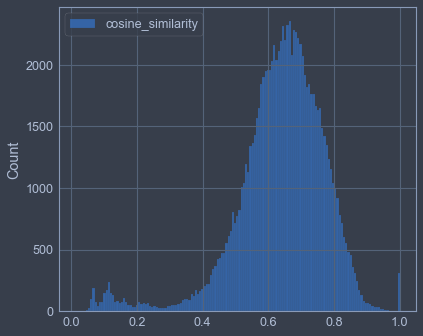

In [171]:
from jupyterthemes import jtplot
jtplot.style()

sns.histplot(cosims_df.sort_values('cosine_similarity', ascending = True));

In [178]:
(cosims_df
         [cosims_df['show'] != cosims_df['other_show']]
        .drop_duplicates(subset=['cosine_similarity'])
        .sort_values('cosine_similarity', ascending = False)[:20]
)

,show,other_show,cosine_similarity
3662,Bo Burnham: Make Happy (2016) – Transcript,Bo Burnham: Inside (2021) – Transcript,0.990612
36522,Bo Burnham: Make Happy (2016) – Transcript,Adam Sandler: 100% Fresh (2018) – Full Transcript,0.986266
3527,Adam Sandler: 100% Fresh (2018) – Full Transcript,Bo Burnham: Inside (2021) – Transcript,0.983647
45806,AMY SCHUMER: MOSTLY SEX STUFF (2012) – Full Tr...,NIKKI GLASER: PERFECT (2016) – Full Transcript,0.963349
82752,Tom Segura: Mostly Stories (2016) – Transcript,Tom Segura: Completely Normal (2014) – Transcript,0.961781
29066,AMY SCHUMER: MOSTLY SEX STUFF (2012) – Full Tr...,Chelsea Peretti: One of the Greats (2014) – Fu...,0.960495
28977,NIKKI GLASER: PERFECT (2016) – Full Transcript,Chelsea Peretti: One of the Greats (2014) – Fu...,0.956929
45798,Donald Glover: Weirdo (2012) – Transcript,NIKKI GLASER: PERFECT (2016) – Full Transcript,0.956021
23653,Chelsea Peretti: One of the Greats (2014) – Fu...,Nikki Glaser: Bangin’ (2019) – Full Transcript,0.954109
23796,AMY SCHUMER: MOSTLY SEX STUFF (2012) – Full Tr...,Nikki Glaser: Bangin’ (2019) – Full Transcript,0.953383


In [170]:
show = 'Jim Gaffigan: Comedy Monster (2021) | Transcript'
(cosims_df
     [cosims_df['show'] != cosims_df['other_show']]
     [cosims_df['show'] == show]
     .sort_values('cosine_similarity')
)

,show,other_show,cosine_similarity
3410,Jim Gaffigan: Comedy Monster (2021) | Transcript,Bo Burnham: Inside (2021) – Transcript,0.104616
5890,Jim Gaffigan: Comedy Monster (2021) | Transcript,"Bo Burnham: Words, Words, Words (2010) – Trans...",0.115871
78120,Jim Gaffigan: Comedy Monster (2021) | Transcript,Bo Burnham: Make Happy (2016) – Transcript,0.160376
36270,Jim Gaffigan: Comedy Monster (2021) | Transcript,Adam Sandler: 100% Fresh (2018) – Full Transcript,0.196862
54250,Jim Gaffigan: Comedy Monster (2021) | Transcript,BRIDGET EVERETT: GYNECOLOGICAL WONDER (2015) –...,0.232105
...,...,...,...
28210,Jim Gaffigan: Comedy Monster (2021) | Transcript,Demetri Martin: Live (At The Time) (2015) | Tr...,0.880536
69130,Jim Gaffigan: Comedy Monster (2021) | Transcript,JEN KIRKMAN: JUST KEEP LIVIN’? (2017) – Full T...,0.880724
41230,Jim Gaffigan: Comedy Monster (2021) | Transcript,JIM GAFFIGAN: NOBLE APE (2018) – Full Transcript,0.885646
31620,Jim Gaffigan: Comedy Monster (2021) | Transcript,Nate Bargatze: Full Time Magic (2015) – Full T...,0.890465


# playground
[to the top](#Feature-Engineering-for-Standup-Scripts)

### Remove brackets and parentheticals, as well as a check to ensure we don't accidentally remove too much
I'd also like to remove intro and exit music programmatically, but that's more fraught. Some shows deliberately contain music as content, and some scripts use an odd number of music signs, which makes it tough to single out lyrics.

In [ ]:
fake_tok = "Thank you, thank you. [applause, laughter] Have you heard what Florida man's up to?"
re.search(r"\[.+\]", fake_tok)

In [ ]:
re.sub(r"\[.+\]", "", fake_tok).strip()

In [ ]:
if fake_tok not in sw and re.search(r"\[.+\]", fake_tok):
    print("Yup, that's true")

In [ ]:
re.sub(r"\[.+?\]", "", transcripts_dict['Tom Papa: Human Mule (2016) – Transcript'])
re.search(r"♪.+?♪", transcripts_dict['Tom Papa: Human Mule (2016) – Transcript'])

In [ ]:
gen = (script for script in transcripts_dict.values())

In [ ]:
re.sub(r"\[.+?\]", "", re.sub(r"♪.+?♪", "", re.sub(r"♪♪.+?♪♪", "", transcripts_dict['Dave Chappelle: The Closer (2021) | Transcript'])))

In [ ]:
mm = metascripts.assign(
    modprop = lambda metascripts: (metascripts['script characters'] - metascripts['transcript'].replace("\[.+?\]|\(.+?\)","", regex = True).apply(len))/metascripts['script characters']
)

px.box(mm, x = 'modprop', hover_data = [mm.index, 'description'])

In [ ]:
metascripts['transcript'][32]

In [ ]:
metascripts['transcript'].replace("\[.+?\]|\(.+?\)","", regex = True)[32]